# Last Mile Delivery

This is very famous and recurring problem in logistics and supply chain management. The problem is about how you can find the optimal schedule for delivering goods from transportation hub to delivery destination. The optimality criteria of this problem and its objectives are very diverse and contradicting like we want to look at the cost of the delivery routes and the time window of the delivery to many destinations and don't forget the dynamic nature of navigation and routing problems and what if the vehicle needs to go back .

This is problem is pretty much like traveling salesman problem in the sense that you need to visit all delivery destination only once in the most optimal way based on your objectives. There is only one relaxed condition in TSP formulation which is that you can visit the transportation hub multiple times because you probably can't serve all delivery destinations demands with loading the vehicle one time, so you need to go back to the transportation hub multiple times between deliveries to load more goods.

---

If the description above is a little confusing, we will formulate the problem step by step explaining the constraints and objectives of the problem and how you can make it more sophisticated and realistice. We also made some utilities in `utilities/src/poi.py` that would help you in this and future case studies and it is first time introduced in the course, so please bear with us.

In [2]:
from utilities import *
import networkx as nx
from tqdm import tqdm
from random import shuffle, randint

### Problem definition

Imagine that we have medical supplies that we want to deliver to some hospitals in Toronto so these are the delivery destinations and the transportation hub would be the King subway station. We want to find the best schedule for our delivering vehicle to follow.

Our deliveing vehicle should visit hospitals only once so we can't deliver hospital's demand of medical supplies in multiple deliveries, so we could go to our transportation hub to get more supplies to distribute to hospitals because the vehicle can't carry unlimited quantities of medical supplies.

---

We will get the data of POIs (point of interest) using `poi` class which takes the name of the place (as saved in OSM databases) and the country of the place to limit the search space and that object will contains the coordinates of that POI and its full address and its OSM id.

We are using [Nominatim](https://nominatim.org/) to do the geodecoding and getting the coordinates of POIs.

In [3]:
sickChildren = poi("Hospital for Sick Children", "canada")
princessMargaret = poi("princess margaret hospital", "canada")
addictionCenter = poi("center for addiction and mental health", "canada")
torontoWestern = poi("toronto western hospital", "canada")
hillcrest = poi("hillcrest reactivation center", "canada")
runnymede = poi("Runnymede Healthcare Centre", "canada")
salvationArmy = poi("Salvation Army Toronto Grace Health Centre", "canada")
michaelGarron = poi("Michael Garron Hospital", "canada")
hollandBloorview = poi("Holland Bloorview Kids Rehabilitation Hospital", "canada")
northYork = poi("North York General Hospital", "canada")
scarborough = poi("Scarborough Health Network - Birchmount", "canada")


kingStation = poi("King Station", "canada")

POIS = [ 
        # hospitals around UofT -- delivery destination
         sickChildren,
         princessMargaret,
         addictionCenter,
         torontoWestern,
         hillcrest,
         runnymede,
         salvationArmy,
         michaelGarron,
         hollandBloorview,
         northYork,
         scarborough,
       
        # king station -- transportation hub
        kingStation
]

Let's explore `poi` object

In [4]:
print(sickChildren.address)
print(sickChildren.coordinates)
# if you print the object as it is, it will print the name of the place and its osmid
print(sickChildren)

Hospital for Sick Children, 555, University Avenue, University—Rosedale, Old Toronto, Toronto, Peel, Golden Horseshoe, Ontario, M5G 1X3, Canada
(-79.38760057839349, 43.657371749999996)
Name: Hospital for Sick Children ID: 712078929


Drawing the POIs on the map for which we only need their coordinates and thanks to nominatim we get them.

In [5]:
# every marker contains a popup with the name of the POI
drawPOIS(POIS, zoom=10)

Map(center=[43.689055504166674, -79.38379344383789], close_popup_on_click=False, controls=(ZoomControl(options…

We will construct a graph between all of the POIs to save the route data between every pair of nodes.

In [6]:
G = nx.DiGraph()
G.add_nodes_from(POIS)

We will be using a method defined for `poi` object that retrieve the route between the object as a source and another object as destination and save it as an edge in the graph.

The method `route_to` uses [OSRM](http://project-osrm.org/) as a routing engine, which returns the coordinates of the route between two coordinates and the length of the route and the expected duration for a vehicle (car-bicycle-foot) to travel that route.

`OSRM` calculates the duration of a route based on multiple criteria like the max speed of the sub-routes and how many turns in the route and how much traffic lights and other obstacles are in the route.

Its calculation is very close to what you would get from google or apple maps, and for how they do that exacly go to [`Project-OSRM/osrm-backend/profiles`](https://github.com/Project-OSRM/osrm-backend/tree/master/profiles) and check how they calculate the traveling time for cars, bicycles, and foot travel.

In [7]:
# this will take 1-2 minutes because you need to find
# two routes between each pair of POIs
for source in G.nodes():
    for destination in G.nodes():
        if source == destination: continue
        G.add_edge(source, destination, route = source.route_to(destination))

Let's see the route object between the nodes

In [8]:
G[sickChildren][princessMargaret]['route']

{'coords': [(43.657832, -79.387362),
  (43.658083, -79.386884),
  (43.657583, -79.389346),
  (43.656302, -79.389103),
  (43.656162, -79.390421),
  (43.658381, -79.391397),
  (43.658519, -79.390787)],
 'length': 850.2,
 'duration': 140.8}

So each edge in the graph has a route object the connects the two adjacent nodes to that edge, which contains the coordinates of that route and its length and estimated travel time.

---
---

### Problem Formulation

We will define a list of delivery destinations which consists of an object/dictionary that describes the POI and its demand and some time interval that the delivery should arrive in.

We are treating the transportation hub the same as delivery destinations but with a negative demand, so when we visit it the capacity of the vehicle increases and arbitrary big time interval so we don't penalize the vehicle any time it returns back to the transportation hub to get more goods.

The following heuristic can solve the problem for arbitrary number of delivery destinations, but with only a single transportation hub. We will talk at the end how to solve the problem with arbitrary number of delivery destionations **and** transportation hubs.

In [9]:
delivery_destinations = [
    {
        'POI':sickChildren, 
        'demand': 50, 
        'time_interval':(0, 300),
    },
    {
        'POI':princessMargaret, 
        'demand':60, 
        'time_interval':(300, 500),
    },
    {
        'POI':addictionCenter, 
        'demand':40, 
        'time_interval':(500, 700),
    },
    {
        'POI':torontoWestern, 
        'demand':85, 
        'time_interval':(700, 900),
    },
    {
        'POI':hillcrest,
        'demand':100, 
        'time_interval':(900, 1200),
    },
    {
        'POI':runnymede, 
        'demand':120, 
        'time_interval':(1200, 1700),
    },
    {
        'POI':salvationArmy, 
        'demand':200, 
        'time_interval':(1700, 2100),
    },
    {
        'POI':michaelGarron, 
        'demand':100, 
        'time_interval':(2400, 3100),
    },
    {
        'POI':hollandBloorview, 
        'demand': 90, 
        'time_interval':(3100, 4000),
    },
    {
        'POI':northYork, 
        'demand':30, 
        'time_interval':(4000, 4500),
    },
    {
        'POI':scarborough, 
        'demand':200, 
        'time_interval':(4700, 5200),
    },
]

#####################################################

transportation_hub = {
    'POI': kingStation,
    'demand': -200,
    'time_interval': (-999999, 999999)
}

As any NP-hard problem we can only solve the problem by approximation, that usually happens by generating solutions and evaluates these solutions by some criteria and hopefully choose the best one.

Our solution would be a certain permutation for the list of delivery destinations with the oocusional occurence of the vehicle returning back to the transportation hub to load some goods, so at the end would be a list of POIs that starts and ends with the transportation hub and in the middle of the list we would have permutation of the delivery destinations and some occusional visits to the transportation hub.

---

### the heuristic function

The heuristic function takes a permutation for the delivery destinations and add the appropriate number of times that the vehicle needs to return to the transportation hub to get more goods, while that it computes the cost of that tour by penalizing when the goods delivered are not withing the time interval and the length of all routes the vehicle between the POIs.

In [10]:
def evaluate_cost(G, delivery_destinations, transportation_hub):
    # accumulative cost of all the moves that would be returned
    cost = 0
    # the starting of the clock
    time = 0
    schedule = list()
    
    # we will begine the schedule by visiting the transportation hub
    schedule.append((transportation_hub['POI'], time))
    # -1 * negative demand of transportation hub so the capacity increase
    current_capacity = -1 * transportation_hub['demand']  
    
    # we will assume at first that the vehicle don't need to go back 
    # to the transportation hub and we will add more as needed while
    # the algorithm is running based on the demand of next stopping point
    complete_tour = [transportation_hub] + delivery_destinations + [transportation_hub]
    
    i = 0
    j = 1
    while j < len(complete_tour):
        start_subroute = complete_tour[i]
        end_subroute = complete_tour[j]
        
        # check if the demand of the next goal
        # could be fulfilled, if not add transportation
        # hub node in the tour and repeat the iteration
        if end_subroute['demand'] > current_capacity:
            complete_tour = complete_tour[:j] + [transportation_hub] + complete_tour[j:]
            continue
            
        # if we are going to deliver goods to destination point
        # deduct its demand from vehicle capacity, but if we 
        # are going to visit transportation hub the capacity will
        # increase
        current_capacity -= end_subroute['demand']
        
        # retrieve the time interval
        time_of_arrival = end_subroute['time_interval']
        
        # calculate the current time of arrival to the destination
        time += G[start_subroute['POI']][end_subroute['POI']]['route']['duration']
        
        # If the time is not within the interval we penalize that 
        # The penalization function doesn't discern if you 
        # arrived before or after the interval
        if int(time) not in range(*time_of_arrival):
            cost += (time - min(time_of_arrival))**2
        
        # add the length of the route to the cost
        cost += G[start_subroute['POI']][end_subroute['POI']]['route']['duration']
        cost += G[start_subroute['POI']][end_subroute['POI']]['route']['length']
        
        # add the visited POI to the scedule and its time
        schedule.append((end_subroute['POI'], time))
        
        # move to the next iteration
        i += 1
        j += 1   
    return cost, schedule
    

In [11]:
# we will need an independent function to calculate the duration
# of the whole schedule so a give solution cost value would make
# sense for us
def calculate_duration(G, schedule):
    # remember that the schedule is
    # a list of tuples (POI, time) so we need
    # to fix that first
    POIs = [pair[0] for pair in schedule]
    cost = 0
    for u, v in zip(POIs, POIs[1:]):
        cost += G[u][v]['route']['duration']
    return cost

We will be be solving the problem using simulated annealing so you start with a random solution and try to change it a little bit every iterations to find the best answer possible

In [12]:
# temperature scheduling function
schedule = exp_schedule(200, 0.05, 10000)

In [13]:
%%time
current = delivery_destinations[:]

states = []
# shuffle the first list
# to get our random solution
shuffle(current)

for t in tqdm(range(sys.maxsize)):
    T = schedule(t)
    
    if T < 0.01:
        # when we arrive at the solution we only need to see the schedule
        # the cost of the schedule is a little bit irrelevant outside the
        # function
        _, solution = evaluate_cost(G, current, transportation_hub)
        break
    
    # generate 5 more random permutations
    # by swapping two children
    neighbors = list()
    for _ in range(5):
        child = current[:]
        i = randint(0, len(child)-1)
        j = randint(0, len(child)-1)
        child[i], child[j] = child[j], child[i]
        neighbors.append(child)
        
    next_choice = random.choice(neighbors)
    
    delta_e = evaluate_cost(G, next_choice, transportation_hub)[0] - evaluate_cost(G, current, transportation_hub)[0]  
    if delta_e < 0 or probability(np.exp(-1 * delta_e/T)):
        current = next_choice
    
    # would be used to visualize the convergence of the algorithm
    _, solution = evaluate_cost(G, current, transportation_hub)
    states.append(calculate_duration(G, solution))

  0%|          | 199/9223372036854775807 [00:00<1173340364993:23:16, 2183.55it/s]

CPU times: user 99.2 ms, sys: 10.3 ms, total: 110 ms
Wall time: 111 ms


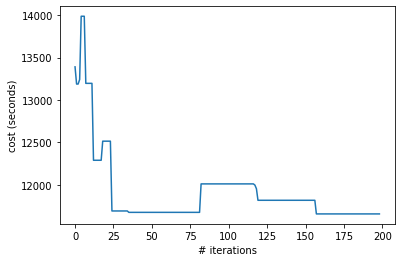

In [14]:
# the solution converged after 100 iterations
import matplotlib.pyplot as plt
plt.xlabel("# iterations")
plt.ylabel("cost (seconds)")
plt.plot(states)
plt.show()

The schedule

In [15]:
solution

[(Name: King Station ID: 697805124, 0),
 (Name: Centre for Addiction and Mental Health (CAMH) Nicotine Dependence Clinic ID: 328900136,
  318.7),
 (Name: Princess Margaret Hospital ID: 712078932, 417.1),
 (Name: Hospital for Sick Children ID: 712078929, 473.90000000000003),
 (Name: King Station ID: 697805124, 699.0),
 (Name: Michael Garron Hospital ID: 447744987, 1491.6),
 (Name: Holland Bloorview Kids Rehabilitation Hospital ID: 684431222, 2194.8),
 (Name: King Station ID: 697805124, 3165.4),
 (Name: Toronto Western Hospital ID: 43805626, 3574.0),
 (Name: Hillcrest Reactivation Centre ID: 7371596851, 3884.1),
 (Name: King Station ID: 697805124, 4516.1),
 (Name: Salvation Army Toronto Grace Health Centre ID: 712086304,
  4845.700000000001),
 (Name: King Station ID: 697805124, 5160.400000000001),
 (Name: Runnymede Healthcare Centre ID: 486817681, 6115.3),
 (Name: North York General Hospital ID: 684426043, 7524.700000000001),
 (Name: King Station ID: 697805124, 8723.900000000001),
 (Name

As you can see we start and finished at King station and hit all the delivery destinations once with occusional returns to the station to get more goods and supplies.

---

Let's visualize the first sub-routes in the schedule

In [16]:
POIs = [pair[0] for pair in solution]
POIs

[Name: King Station ID: 697805124,
 Name: Centre for Addiction and Mental Health (CAMH) Nicotine Dependence Clinic ID: 328900136,
 Name: Princess Margaret Hospital ID: 712078932,
 Name: Hospital for Sick Children ID: 712078929,
 Name: King Station ID: 697805124,
 Name: Michael Garron Hospital ID: 447744987,
 Name: Holland Bloorview Kids Rehabilitation Hospital ID: 684431222,
 Name: King Station ID: 697805124,
 Name: Toronto Western Hospital ID: 43805626,
 Name: Hillcrest Reactivation Centre ID: 7371596851,
 Name: King Station ID: 697805124,
 Name: Salvation Army Toronto Grace Health Centre ID: 712086304,
 Name: King Station ID: 697805124,
 Name: Runnymede Healthcare Centre ID: 486817681,
 Name: North York General Hospital ID: 684426043,
 Name: King Station ID: 697805124,
 Name: Scarborough Health Network - Birchmount Hospital ID: 681295730,
 Name: King Station ID: 697805124]

In [17]:
first_route = G[POIs[0]][POIs[1]]['route']['coords']

In [18]:
drawRoute(first_route)

Map(center=[43.651889, -79.381734], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title'…

In [19]:
second_route = G[POIs[1]][POIs[2]]['route']['coords']

In [20]:
drawRoute(second_route)

Map(center=[43.659199, -79.393501], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title'…

In [21]:
third_route = G[POIs[2]][POIs[3]]['route']['coords']

In [22]:
drawRoute(third_route)

Map(center=[43.657527, -79.389624], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title'…

In [23]:
fourth_route = G[POIs[3]][POIs[4]]['route']['coords']

In [24]:
drawRoute(fourth_route)

Map(center=[43.656432, -79.384008], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title'…

## Dealing with multiple transportation hubs

As you probably see, the last mile delivery problem with a single transportation hub and arbitrary number of delivery destinations is trivial and its running time for generating new solutions and getting their cost was rather fast because all you have to do is just manipulating a single array of objects.

But handling multiple transportation hubs is completely different beast. The problem could be solved by reducing the problem to a network flow problem, where we would have bipartite graph with two different vertex sets: the first one is the set containing all the delivery destinations and the other set containing all transportation hubs. Your problem is to find the maximum flow and maximum matching between the tranportation hub vertices and delivery destinations vertices and you can add the constraints like time windows and capacity of the vehicles as extra layer of vertices between the layer of transportation hubs and the layer of vertices of delivery destinations.

Solving your problem as flow problem will give you the **exact** solution for the scheduling and you don't need to resort for approximations most of the time. Linear programming is used to solve these kind of problems, but you need to be aware that linear programming solutions sometimes under some conditions can degenerate to exponential and intractable problems, in that case we resort to approximation search algorithms like SA and genetic algorithm.